In [1]:
import pandas as pd
from dateutil import parser
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
import pickle
nat = np.datetime64('NaT')

In [3]:
import pandas as pd
admission_table=pd.read_csv('data/ADMISSIONS.csv')
notes_table=pd.read_csv('data/NOTEEVENTS.csv')
data_merged = pd.merge(notes_table, admission_table, how='left', on=['SUBJECT_ID', 'HADM_ID'])

In [ ]:
# take the first addmission time 
admission_table['ADMITTIME']=admission_table['ADMITTIME'].map(lambda x: parser.parse(x))
sub_hops_admission = admission_table.groupby(['SUBJECT_ID'])['ADMITTIME'].unique()
sub_hops_admission = sub_hops_admission.map(lambda x: sorted(x)[0])
first_adm = pd.DataFrame({'SUBJECT_ID': sub_hops_admission.index,'ADMITTIME':sub_hops_admission.values })
first_adm = pd.merge(first_adm, admission_table, how = 'left', on = ['SUBJECT_ID','ADMITTIME' ] )
id_first = set(first_adm['HADM_ID'])
label = [x in id_first for x in data_merged['HADM_ID'] ]

In [ ]:
len(first_adm)
data_merged = data_merged[label]
len(data_merged)
len(notes_table)
data_merged = data_merged[~pd.isnull(data_merged['CHARTTIME'])]
len(data_merged)
data_merged.columns
data_merged['DISCHARGE_LOCATION'].unique()
data_merged['CATEGORY'].unique()
sum(pd.isnull(data_merged['DEATHTIME']))/len(data_merged)
type(data_merged['DEATHTIME'][308691])
data_merged['DEATHTIME']= [parser.parse(x) if type(x)!=float else x for x in data_merged['DEATHTIME']]
data_merged['DEATHTIME'] = pd.to_datetime(data_merged['DEATHTIME'])
print('DEATHTIME')
data_merged['ADMITTIME']=data_merged['ADMITTIME'].map(lambda x: parser.parse(x))
print('ADMITTIME')
data_merged['DISCHTIME']=data_merged['DISCHTIME'].map(lambda x: parser.parse(x))
print('DISCHTIME')
data_merged['CHARTTIME']=data_merged['CHARTTIME'].map(lambda x: parser.parse(x))
print('CHARTTIME')
time_only = data_merged[~pd.isnull(data_merged['DEATHTIME'])][['SUBJECT_ID','CHARTTIME', 'DISCHTIME','DEATHTIME']]
len(time_only[time_only['DEATHTIME'] != time_only['DISCHTIME']]['SUBJECT_ID'].unique())
subject_ID_list = data_merged['SUBJECT_ID'].unique()
print( sum(data_merged.groupby(['SUBJECT_ID'])['DISCHTIME'].nunique() != 1))
print( sum(data_merged.groupby(['SUBJECT_ID'])['ADMITTIME'].nunique() != 1))
print( sum(data_merged.groupby(['SUBJECT_ID'])['DEATHTIME'].nunique() > 1))
CHARTTIMElist = data_merged.groupby(['SUBJECT_ID'])['CHARTTIME'].unique()
ADMITTIMElist = data_merged.groupby(['SUBJECT_ID'])['ADMITTIME'].unique()
DEATHTIMElist = data_merged.groupby(['SUBJECT_ID'])['DEATHTIME'].unique()
DISCHTIMElist = data_merged.groupby(['SUBJECT_ID'])['DISCHTIME'].unique()
sub_time_dictionary = {}
for sub in subject_ID_list:
    sub_time_dictionary[sub] = {}
    sub_time_dictionary[sub]['CHARTTIME'] = CHARTTIMElist[sub]
    sub_time_dictionary[sub]['ADMITTIME'] = ADMITTIMElist[sub]
    sub_time_dictionary[sub]['DEATHTIME'] = DEATHTIMElist[sub]
    sub_time_dictionary[sub]['DISCHTIME'] = DISCHTIMElist[sub]


error_sub = []

for sub in subject_ID_list:
    sub_time_dictionary[sub]['CHARTTIME_valid'] = [x for x in sub_time_dictionary[sub]['CHARTTIME'] 
                                                   if x < sub_time_dictionary[sub]['DISCHTIME']]
    try:
        sub_time_dictionary[sub]['CHARTTIME_interval'] = (sub_time_dictionary[sub]['CHARTTIME_valid'] - 
                                                          sub_time_dictionary[sub]['ADMITTIME']).astype('timedelta64[m]')
    except TypeError:
        #print(sub)
        error_sub.append(sub)
        
error_adult = []
for sub in error_sub:
    if sub_time_dictionary[sub]['ADMITTIME'] > sub_time_dictionary[sub]['DEATHTIME'] and sub in subject_adult:
        #print('error',sub)
        error_adult.append(sub)
    else:
        pass
    
        #print(sub) 

In [3]:
valid_subject = pd.read_csv('data/id_inhospital_deathtime.csv', index_col = 0)
print(sum(pd.isnull(valid_subject['DEATHTIME'])))
subject_adult = valid_subject['SUBJECT_ID']
valid_subject['DEATHTIME']= [parser.parse(x) if type(x)!=float else x for x in valid_subject['DEATHTIME']]
valid_subject['DEATHTIME'] = pd.to_datetime(valid_subject['DEATHTIME'])

31369


In [ ]:
sub_time_dictionary_final = {}
for sub in valid_sub_final:
    sub_time_dictionary_final[sub] = sub_time_dictionary[sub]

for sub in valid_sub_final:
    sub_time_dictionary_final[sub]['DEATHTIME'] = np.array(valid_subject[valid_subject['SUBJECT_ID'] == sub]['DEATHTIME'])

with open('data/patient_timesheet_final.pickle', 'wb') as handle:
    pickle.dump(sub_time_dictionary_final, handle)
  

In [38]:
# summary table creation
def summary_table_creation(time_dictionary, valid_sub):
    time_interval = np.array([15, 6*60, 12*60, 24*60]).astype('timedelta64[m]')

    notes_counts = {}
    for sub in valid_sub:
        try:
            sub_list = np.zeros(5)
            for interval in time_dictionary[sub]['CHARTTIME_interval']:
                if interval<=time_interval[0]:
                    sub_list[0] += 1
                if interval<=time_interval[1]:
                    sub_list[1] += 1
                if interval<=time_interval[2]:
                    sub_list[2] += 1
                if interval<=time_interval[3]:
                    sub_list[3] += 1
            sub_list[4] = len(time_dictionary[sub]['CHARTTIME_interval']) 
            notes_counts[sub] = sub_list
        except KeyError:
            #print(sub)
            #error_sub.append(sub)
            pass 
    notes_counts_table = pd.DataFrame(notes_counts).T
    notes_counts_table.columns  = ['15 minutes', '6 hours', '12 hours', '24 hours', 'Over 24 hours']
    return notes_counts, notes_counts_table

In [58]:
valid_sub_after_admission = valid_sub_final - set(subject_no_valid_notes)

15 minutes:  [ 0.  1.  2.  3.]
6 hours:  [ 2.  1.  0.  4.  5.  3.  6.  7.  8.  9.]
12 hours:  [  4.   1.   3.   2.   0.   5.   6.   7.   9.   8.  11.  10.  13.]
24 hours:  [  6.   4.   5.   2.   3.   1.   0.   7.  14.  10.   9.   8.  13.  11.  12.
  15.  17.  16.  18.]


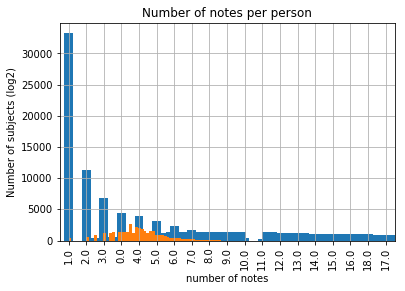

In [62]:
notes_counts, notes_counts_table = summary_table_creation(sub_time_dictionary_final, valid_sub_after_admission)

notes_counts_table['15 minutes'].value_counts().plot.bar(title = '15 minutes')
plt.xlabel('number of notes')

notes_counts_table['6 hours'].value_counts().plot.bar(title = '6 hours')
plt.xlabel('number of notes')

notes_counts_table['12 hours'].value_counts().plot.bar(title = '12 hours')
plt.xlabel('number of notes')

notes_counts_table['24 hours'].value_counts().plot.bar(title = '24 hours')
plt.xlabel('number of notes')

# notes_counts_table['Over 24 hours'].value_counts().plot.hist(bins = 30, title = 'Over 24 hours')
# plt.xlabel('number of notes')

notes_counts_table[['15 minutes', '6 hours', '12 hours', '24 hours', 'Over 24 hours']].sum(1).hist(bins = 1000)
plt.title('Number of notes per person')

np.log2(notes_counts_table[['15 minutes', '6 hours', '12 hours', '24 hours', 'Over 24 hours']].sum(1)).hist(bins = 60)
plt.title('Number of notes per person')
plt.ylabel('Number of subjects (log2)')

print('15 minutes: ',str(notes_counts_table['15 minutes'].unique()))
print('6 hours: ',str(notes_counts_table['6 hours'].unique()))
print('12 hours: ',str(notes_counts_table['12 hours'].unique()))
print('24 hours: ',str(notes_counts_table['24 hours'].unique()))
notes_counts_table.to_csv('notes_summary.csv')

In [69]:
sub_with_notes_in_15min = notes_counts_table[notes_counts_table['15 minutes']!= 0].index
death_time 
for sub in sub_with_notes_in_15min:

In [61]:
notes_counts_table['SUBJECT_ID'] = notes_counts_table.index
print(notes_counts_table.columns)
print('Number of subjects with less than 3 notes:', sum(notes_counts_table.sum(1) < 3))
print('NUmber of subjects : ', len(notes_counts_table))
print('Number of notes:')
print(str((notes_counts_table).sum(0)))
print('Number of patients:')
print(str((notes_counts_table>0).sum(0)))

notes_counts_table_with_time = pd.merge(notes_counts_table, valid_subject, how = 'left', on = ['SUBJECT_ID'])
notes_counts_table_with_recover = notes_counts_table_with_time[notes_counts_table_with_time.DEATHTIME.isnull()]
notes_counts_table_with_death = notes_counts_table_with_time[~notes_counts_table_with_time.DEATHTIME.isnull()]
notes_counts_table_with_death[['15 minutes', '6 hours', '12 hours', '24 hours', 'Over 24 hours']].sum().sum()
print('Number of notes:')
print(str(notes_counts_table_with_death.sum(0)))
print('Number of patients:')
print(str((notes_counts_table_with_death>0).sum(0)))

Index(['15 minutes', '6 hours', '12 hours', '24 hours', 'Over 24 hours',
       'SUBJECT_ID'],
      dtype='object')
Number of subjects with less than 3 notes: 0
NUmber of subjects :  34263
Number of notes:
15 minutes       1.133000e+03
6 hours          3.166800e+04
12 hours         6.119900e+04
24 hours         1.124970e+05
Over 24 hours    6.616610e+05
SUBJECT_ID       1.254829e+09
dtype: float64
Number of patients:
15 minutes        1065
6 hours          19103
12 hours         26678
24 hours         30383
Over 24 hours    34263
SUBJECT_ID       34263
dtype: int64
Number of notes:
15 minutes             177.0
6 hours               5058.0
12 hours              9347.0
24 hours             16989.0
Over 24 hours       143420.0
SUBJECT_ID       150638406.0
dtype: float64
Number of patients:
15 minutes        172
6 hours          2785
12 hours         3605
24 hours         4069
Over 24 hours    4656
SUBJECT_ID       4656
DEATHTIME        4656
dtype: int64


In [47]:
with open('data/patient_timesheet_final.pickle', 'rb') as handle:
     sub_time_dictionary_final = pickle.load(handle)
        
valid_sub_final = set(sub_time_dictionary_final.keys()) & set(valid_subject['SUBJECT_ID']) 

      

In [48]:
for sub in valid_sub_final:
    sub_time_dictionary_final[sub]['CHARTTIME_valid'] = [x for x in sub_time_dictionary_final[sub]['CHARTTIME'] 
                                                   if x < sub_time_dictionary_final[sub]['DISCHTIME'] and x >sub_time_dictionary_final[sub]['ADMITTIME']]
    
error_sub = []
for sub in valid_sub_final:
    try:
        sub_time_dictionary_final[sub]['CHARTTIME_interval'] = (sub_time_dictionary_final[sub]['CHARTTIME_valid'] - 
                                                          sub_time_dictionary_final[sub]['ADMITTIME']).astype('timedelta64[m]')
    except TypeError:
        #print(sub)
        error_sub.append(sub)
        
# sub_for_table = []
# charttime_for_table = []
# for sub in sub_time_dictionary_final:
#     for charttime in sub_time_dictionary_final[sub]['CHARTTIME']:
#         notes_table_useful[notes_table_useful['SUBJECT_ID'] == sub][notes_table_useful['CHARTTIME'] == charttime]['TEXT']

error_sub = []
stay_interval = []
for sub in valid_sub_final:
    try:
        sub_time_dictionary_final[sub]['Stay_interval'] = (sub_time_dictionary_final[sub]['DISCHTIME'] - 
                                                          sub_time_dictionary_final[sub]['ADMITTIME']).astype('timedelta64[D]')
        stay_interval.append(sub_time_dictionary_final[sub]['Stay_interval'][0].astype(int))
    except TypeError:
        #print(sub)
        error_sub.append(sub)

error_sub = []
for sub in valid_sub_final:
    try:
        sub_time_dictionary_final[sub]['CHARTTIME_todeath'] = (sub_time_dictionary_final[sub]['DISCHTIME'] - 
                                                          sub_time_dictionary_final[sub]['CHARTTIME_valid']).astype('timedelta64[m]')
    except TypeError:
        #print(sub)
        error_sub.append(sub)

In [55]:
subject_no_valid_notes = []
for sub in valid_sub_final:
    if len(sub_time_dictionary_final[sub]['CHARTTIME_valid']) == 0:
        subject_no_valid_notes.append(sub)

In [56]:
len(subject_no_valid_notes)

609

In [12]:
stay_interval = np.array(stay_interval)

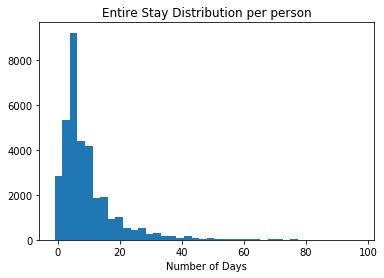

In [13]:
plt.hist(stay_interval[stay_interval<100], bins = 40)
plt.title('Entire Stay Distribution per person')
plt.xlabel('Number of Days')

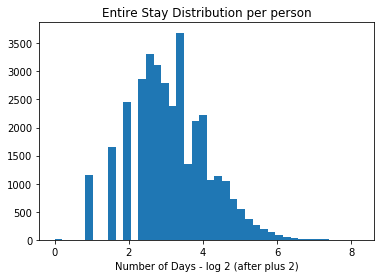

In [471]:
plt.hist(np.log2(stay_interval+2), bins = 40)
plt.title('Entire Stay Distribution per person')
plt.xlabel('Number of Days - log 2 (after plus 2)')

In [401]:
notes_table_useful = notes_table[notes_table['SUBJECT_ID'].isin(valid_sub_final)]
notes_table_useful['CHARTTIME']= [parser.parse(x) if type(x)!=float else x for x in notes_table_useful['CHARTTIME']]
notes_table_useful['CHARTTIME'] = pd.to_datetime(notes_table_useful['CHARTTIME'])
notes_table_useful = notes_table_useful[~pd.isnull(notes_table_useful['CHARTTIME'])]

/Users/apple/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/apple/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [402]:
documents = list(notes_table_useful['TEXT'])
CHARTTIME = list(notes_table_useful['CHARTTIME'])
SUBJECT_ID = list(notes_table_useful['SUBJECT_ID'])

final_data = {'CHARTTIME':CHARTTIME, 'SUBJECT_ID':SUBJECT_ID,'DOCUMENTS':cleaned_doc }
len(CHARTTIME),len(SUBJECT_ID),len(cleaned_doc)

with open('data/cleaned_notes.pickle', 'wb') as handle:
    pickle.dump(final_data, handle)

In [ ]:
final_data = {'CHARTTIME':CHARTTIME, 'SUBJECT_ID':SUBJECT_ID,'DOCUMENTS':cleaned_doc }
len(CHARTTIME),len(SUBJECT_ID),len(cleaned_doc)
with open('cleaned_notes.pickle', 'wb') as handle:
    pickle.dump(final_data, handle)

In [ ]:
with open('data/cleaned_notes.pickle', 'wb') as handle:
    pickle.dump(final_data, handle)

In [556]:
final_data_df = pd.DataFrame(final_data)

In [558]:
final_data_df.to_csv('data/cleaned_notes.csv')

In [567]:
final_data

In [545]:
len(CHARTTIME),len(SUBJECT_ID),len(cleaned_doc)

(1280007, 1280007, 1280007)

In [132]:
#sorted(unique_iden)[1000:2000]

In [249]:
import sys
sys.path.append('data_preprocessing/')

In [430]:
import identification_transformer 

def find_unique_identification(documents):
    '''
    final all unique identification 

    Returns:
       A list of unique identications
    '''
    identifications = []
    for note in documents:
        i = 0
        while i <len(note):
            if note[i] == '[' and note[i+1] == '*':
                j = i+1
                while note[j-1] != '*' or note[j] != ']':
                    j+=1
                identifications.append(note[i:j+1])
            i+=1
    return list(set(identifications))


def find_standrad_identification(identification):
    return transformer(identification)

In [431]:
unique_iden = find_unique_identification(documents)
#iden_list = [x[3:-3] for x in unique_iden]
len(unique_iden)

['[**Name2 (NI) 5018**]',
 '[**Last Name (STitle) 9590**]',
 '[**Last Name (NamePattern1) 2196**]',
 '[**Country 3802**]',
 '[**Telephone/Fax (1) 18661**]',
 '[**Clip Number (Radiology) 65755**]',
 '[**2122-10-15**]',
 '[**2169-7-9**]',
 '[**Clip Number (Radiology) 66528**]',
 '[**Serial Number 59229**]']

In [432]:

unique_identifications = unique_iden
standrad_identifications = []
for identification in  unique_identifications:
    standrad_identifications.append(find_standrad_identification(identification[3:-3]))
unique_identification_dictionary = dict(zip(unique_identifications, standrad_identifications)) 


In [411]:
len(set(unique_identification_dictionary.values()))

12

In [412]:
for x in sorted(list(set(unique_identification_dictionary.values()))):
    print(x, end = ' ')

   COMPANY CONTACT DATE HOSPITAL LOCATION NAME NUMBER NUMERIC_IDENTIFIER UNIVERSITY URL 

In [414]:
import data_cleaning
import time

In [442]:
def find_unique_identification(documents, unique_identification_dictionary):
    '''
    final all unique identification 

    Returns:
       A list of unique identications
    '''
    identifications = []
    new_documents = []
    print(len(documents))
    all_l = len(documents)
    num = 0
    start = time.time()
    for note in documents:
        num+=1
        if num%1000 == 0:
            print('Processed: ', time.time() - start, num/all_l)
        i = 0
        new = note
        while i <len(note):
            if note[i] == '[' and note[i+1] == '*':
                j = i+1
                while note[j-1] != '*' or note[j] != ']':
                    j+=1
                identifications.append(note[i:j+1])
                #print(unique_identification_dictionary[note[i:j+1]])
                #new = new[:i] + [x for x in unique_identification_dictionary[note[i:j+1]]] + new[j+2:]
                if len(unique_identification_dictionary) != 0:
                    new = new.replace(note[i:j+1] ,unique_identification_dictionary[note[i:j+1]])
                else:
                    new = new.replace(note[i:j+1] ,find_standrad_identification(note[i:j+1][3:-3]))
                #print(note[i:j+1], unique_identification_dictionary[note[i:j+1]])
                #print(new)
            i+=1
        new_documents.append(new)
            
    return list(set(identifications)), new_documents

In [561]:
start = time.time()
_, cleaned_doc= find_unique_identification(documents,[])
print(time.time() - start)

In [444]:
cleaned_doc = data_cleaning.clean_spaces(cleaned_doc)
cleaned_doc = [x.lower() for x in cleaned_doc]

In [428]:
def identification_reform(documents, unique_identification_dictionary):
    '''
    Args:
        documents: orignal data
        unique_identification_dictionary: {'**name1**': 'FIRSTNAME' ....}
    Returns:
             cleaned_doc: all identification replace by a standrad symbol
     '''
     
    cleaned_doc = []
    for note in documents:
        for identification in unique_identification_dictionary.keys():
            note = note.replace(identification, unique_identification_dictionary[identification])
        cleaned_doc.append(note)
    return cleaned_doc

def clean_spaces(documents):
    cleaned_doc = []
    for note in documents:
        single_space_note = ' '.join(note.split())
        cleaned_doc.append(single_space_note)
    return cleaned_doc


In [358]:
import string
def word_tokenize(documents):
    cleaned_doc = []
    translator = str.maketrans('', '', string.punctuation)
    _treebank_word_tokenizer = TreebankWordTokenizer()
    for note in documents:
        note = note.translate(translator)
        note = note.replace('0','#')
        note = note.replace('1','#')
        note = note.replace('2','#')
        note = note.replace('3','#')
        note = note.replace('4','#')
        note = note.replace('5','#')
        note = note.replace('6','#')
        note = note.replace('7','#')
        note = note.replace('8','#')
        note = note.replace('9','#')
        tokenized_note = _treebank_word_tokenizer.tokenize(note)
        cleaned_doc.append(tokenized_note)
    return cleaned_doc

In [359]:
from nltk.tokenize.treebank import TreebankWordTokenizer

In [360]:
start = time.time()
tokens = word_tokenize(cleaned_doc[:1000])
print(time.time() - start)

In [177]:
auc_calculation('val_15m', './model/val_15m_wc20_dim300_epoch80.prob',labels_dict)

0.78512426311168448